## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import linalg, optimize
import re
import random
import math
import string
from nltk.corpus import wordnet as wn
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize
from scipy import optimize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack, vstack
import seaborn as sns
from textblob import TextBlob
# Graphing: 
%matplotlib inline


ModuleNotFoundError: No module named 'textblob'

## Reading in Data Files

> * Training Set
> * Training Labels 
> * Testing Set
> * Testing Labels

> * Floor Pickle File for Mapping
> * Property Pickle File for Mapping
> * Street Pickle File for Mapping

In [14]:
# train_set = 'https://raw.githubusercontent.com/nicolepng/BT4222/master/Data/training_set.csv'
# train_labels = 'https://raw.githubusercontent.com/nicolepng/BT4222/master/Data/training_labels.csv'
# test_set = 'https://raw.githubusercontent.com/nicolepng/BT4222/master/Data/testing_set.csv'
# test_labels = 'https://raw.githubusercontent.com/nicolepng/BT4222/master/Data/testing_labels.csv'


In [6]:
# train_set = '/content/training_set.csv'
# train_labels = '/content/training_labels.csv'
# test_set = '/content/testing_set.csv'
# test_labels = '/content/testing_labels.csv'
combined = '/Users/vickiyew/Desktop/bt4222_data/combined.csv'

In [7]:
# training_set = pd.read_csv(train_set)
# testing_set = pd.read_csv(test_set)
# training_labels= pd.read_csv(train_labels)
# testing_labels = pd.read_csv(test_labels)
df = pd.read_csv(combined)

In [8]:
df.drop(df.columns[0], axis = 1, inplace=True)
df.head()

,district,street,propertyType,remaining_lease,price,school,hawkercentre,supermarkets,Bus Stops Nearby,crime_number,latitude,longitude,floor_area_sqm,floor_range,sentiment
0,5,ZEHNDER ROAD,Semi-detached,999.00,5500000.0,27,6,8,0,-1.0,1.282130,103.786879,524.3,~-,0.380502
1,5,ZEHNDER ROAD,Semi-detached,999.00,5000000.0,27,6,8,0,-1.0,1.282130,103.786879,308.0,~-,0.123495
2,5,ZEHNDER ROAD,Semi-detached,999.00,4750000.0,27,6,8,0,-1.0,1.282130,103.786879,314.0,~-,0.123495
3,5,NEO PEE TECK LANE,Terrace,999.00,2630000.0,27,6,8,2,-1.0,1.292047,103.768591,159.3,~-,0.380502
4,4,COVE DRIVE,Condominium,85.25,3180000.0,11,3,2,0,-1.0,1.244208,103.827487,194.0,~01-05,0.173732


In [9]:
df['street'] = df['street'].astype('category')
street_dict = dict(zip(df['street'].cat.codes, df['street']))
df['street'] = df['street'].cat.codes

df['propertyType'] = df['propertyType'].astype('category')
property_dict = dict(zip(df['propertyType'].cat.codes, df['propertyType']))
df['propertyType'] = df['propertyType'].cat.codes

df['floor_range'] = df['floor_range'].astype('category')
floor_dict = dict(zip(df['floor_range'].cat.codes, df['floor_range']))
df['floor_range'] = df['floor_range'].cat.codes

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1),
                                                    df['price'], 
                                                    test_size=0.2,
                                                    random_state=1)

## With Feature Cross


> LIGHTGBM

## REFER TO THIS FOR LIGHTGBM RESULTS WITH FEATURE CROSS

> Training Errors
> * Mean Squared Error:  206023460110.6487
> * RMSE:  453898.0723804065
> * Mean Absolute Error:  111724.82261478397
> * R-squared:  0.9263901510218109
> * Adjusted R2:  0.9263805141525729
> * Training sMAPE: 9.985563141154232
> * Training MAPE: 10.89849496263378


> Test Errors
> * Mean Squared Error:  163867462293.10486
> * RMSE:  404805.46228170494
> * Mean Absolute Error:  118310.99300350671
> * R-squared:  0.9221484581146083
> * Adjusted R2:  0.9221076722153307
> * Testing sMAPE: 10.164487527219974
> * Testing MAPE: 10.305690774964821

In [11]:
_, longitude_boundaries = np.histogram(X_train['longitude'])
_, latitude_boundaries = np.histogram(X_train['latitude'])

def assign_bucket(x, ranges):
    if x <= ranges[0]:
        return 0
    
    for i in range(1, len(ranges) - 1):
        if x <= ranges[i]:
            return i - 1
    return len(ranges) - 2

X_train['lgt_discrete'] = X_train['longitude'].apply(lambda x: assign_bucket(x, longitude_boundaries))
X_train['lat_discrete'] = X_train['latitude'].apply(lambda x: assign_bucket(x, latitude_boundaries))
X_test['lgt_discrete'] = X_test['longitude'].apply(lambda x: assign_bucket(x, longitude_boundaries))
X_test['lat_discrete'] = X_test['latitude'].apply(lambda x: assign_bucket(x, latitude_boundaries))

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto')
features_lat_lgn_train = enc.fit_transform(X_train[['lgt_discrete', 'lat_discrete']]) # fit and transform TRAIN
features_lat_lgn_test = enc.transform(X_test[['lgt_discrete', 'lat_discrete']]) # transform only TEST

In [13]:
features_to_drop = ['longitude', 'latitude', 'lgt_discrete', 'lat_discrete']
OHE_train = np.hstack((X_train.drop(features_to_drop, axis=1).values, features_lat_lgn_train.toarray()))
OHE_test = np.hstack((X_test.drop(features_to_drop, axis=1).values, features_lat_lgn_test.toarray()))

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

# Initialise LGBMRegressor
# rf = LGBMRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')
optimized_rf = LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=0.3, eval_metric='rmse',
                               importance_type='split', learning_rate=0.1,
                               max_depth=8, min_child_samples=20,
                               min_child_weight=0.001, min_samples_leaf=2,
                               min_split_gain=0.0, n_estimators=300, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=0.7, subsample_for_bin=200000,
                               subsample_freq=0)


# # # Set up 5-fold cross-validation
# from sklearn import model_selection
# cv = model_selection.KFold(5)


# # Pipeline Standardization and Model
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
#                            , ('model', rf) ])
# # Tuning the model
# my_min_samples_leaf = [2, 10, 25, 50, 100]
# my_max_depth = [7, 8, 9, 10, 11, 12]
# my_subsample = [0.7, 0.8, 0.9]
# my_colsample_bytree = [0.1, 0.2, 0.3]

# # Run the model using GridSearch, select the model with best search
# from sklearn.model_selection import GridSearchCV
# optimized_rf = GridSearchCV(estimator=pipeline
#                             , cv=cv
#                             , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, 
#                                                model__max_depth = my_max_depth,
#                                                model__subsample = my_subsample,
#                                                model__colsample_bytree = my_colsample_bytree)
#                             , scoring = 'neg_mean_squared_error'
#                             , verbose = 1
#                             , n_jobs = -1
#                            )

# Fitting on Training Data
optimized_rf.fit(OHE_train, y_train)


# Best model estimators
# print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(OHE_train)
y_pred = optimized_rf.predict(OHE_test)
n1 = len(y_train_pred)
p1 = training_set.shape[1]
n2 = len(y_pred)
p2 = testing_set.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("RMSE: ", mean_squared_error(y_train, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_train_pred))
print("R-squared: ", r2_score(y_train, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_train, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("R-squared: ", r2_score(y_test, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_test, y_pred), n2, p2))



Training Errors
Mean Squared Error:  206023460110.6487
RMSE:  453898.0723804065
Mean Absolute Error:  111724.82261478397
R-squared:  0.9263901510218109
Adjusted R2:  0.9263805141525729
Test Errors
Mean Squared Error:  163867462293.10486
RMSE:  404805.46228170494
Mean Absolute Error:  118310.99300350671
R-squared:  0.9221484581146083
Adjusted R2:  0.9221076722153307


In [22]:
def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred.squeeze()-y_true.squeeze()) / (np.abs(y_true.squeeze()) + np.abs(y_pred.squeeze()))*100)


print('Training sMAPE')
print(smape(y_train_pred, y_train))
print('Testing sMAPE')
print(smape(y_pred, y_test))

Training sMAPE
9.985563141154232
Testing sMAPE
10.164487527219974


In [23]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print('Training MAPE')
print(mape(y_train_pred, y_train))
print('Testing MAPE')
print(mape(y_pred, y_test))

Training MAPE
10.89849496263378
Testing MAPE
10.305690774964821


> XGBOOST

## *** REFER TO THIS FOR THE XGBOOST RESULS WITH FEATURE CROSS **

> Training Errors
> * Mean Squared Error:  12551992028.521044
> * RMSE:  112035.67301766454
> * Mean Absolute Error:  51479.346560496706
> * R-squared:  0.9955153154058346
> * Adjusted R2:  0.9955147282789812
> * Training sMAPE: 5.418052917646694
> * Training MAPE: 5.41039623682465



> Test Errors
> * Mean Squared Error:  72116357746.47386
> * RMSE:  268544.8896301582
> * Mean Absolute Error:  74558.02547936206
> * R-squared:  0.9657383499618781
> * Adjusted R2:  0.9657204005138171
> * Testing sMAPE: 6.164298821910724
> * Testing MAPE: 6.1527569561702355

##  SHAP TEST

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error
import xgboost
from xgboost import XGBRegressor


# Initialise LGBMRegressor
# rf = LGBMRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')
optimized_rf = XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=0.2,
                              colsample_bytree=1, eval_metric='rmse', gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, min_samples_leaf=2,
                              missing=None, n_estimators=300, n_fold=5,
                              n_jobs=1, nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=0.9, verbosity=1)


# # # Set up 5-fold cross-validation
# from sklearn import model_selection
# cv = model_selection.KFold(5)


# # Pipeline Standardization and Model
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
#                            , ('model', rf) ])
# # Tuning the model
# my_min_samples_leaf = [2, 10, 25, 50, 100]
# my_max_depth = [7, 8, 9, 10, 11, 12]
# my_subsample = [0.7, 0.8, 0.9]
# my_colsample_bytree = [0.1, 0.2, 0.3]

# # Run the model using GridSearch, select the model with best search
# from sklearn.model_selection import GridSearchCV
# optimized_rf = GridSearchCV(estimator=pipeline
#                             , cv=cv
#                             , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, 
#                                                model__max_depth = my_max_depth,
#                                                model__subsample = my_subsample,
#                                                model__colsample_bytree = my_colsample_bytree)
#                             , scoring = 'neg_mean_squared_error'
#                             , verbose = 1
#                             , n_jobs = -1
#                            )

# Fitting on Training Data
optimized_rf.fit(OHE_train, y_train)


# Best model estimators
# print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(OHE_train)
y_pred = optimized_rf.predict(OHE_test)
n1 = len(y_train_pred)
p1 = X_train.shape[1]
n2 = len(y_pred)
p2 = X_test.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("RMSE: ", mean_squared_error(y_train, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_train_pred))
print("R-squared: ", r2_score(y_train, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_train, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("R-squared: ", r2_score(y_test, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_test, y_pred), n2, p2))


def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred.squeeze()-y_true.squeeze()) / (np.abs(y_true.squeeze()) + np.abs(y_pred.squeeze()))*100)


print('Training sMAPE')
print(smape(y_train_pred, y_train))
print('Testing sMAPE')
print(smape(y_pred, y_test))

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print('Training MAPE')
print(mape(y_train_pred, y_train))
print('Testing MAPE')
print(mape(y_pred, y_test))

[23:11:09] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:11:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { min_samples_leaf, n_fold } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Training Errors
Mean Squared Error:  12343898214.519537
RMSE:  111103.0972318933
Mean Absolute Error:  51215.69369614373
R-squared:  0.9955896649688102
Adjusted R2:  0.9955890050785918
Test Errors
Mean Squared Error:  68478261317.63118
RMSE:  261683.51365271595
Mean Absolute Error:  73709.02318700777
R-squared:  0.9674667676266768
Adjusted R2:  0.967447287378259
Training sMAPE
5.434529165435634
Testing sMAPE
6.166556529356623
Training MAPE
5.42567347038599
Testing MAPE
6.1

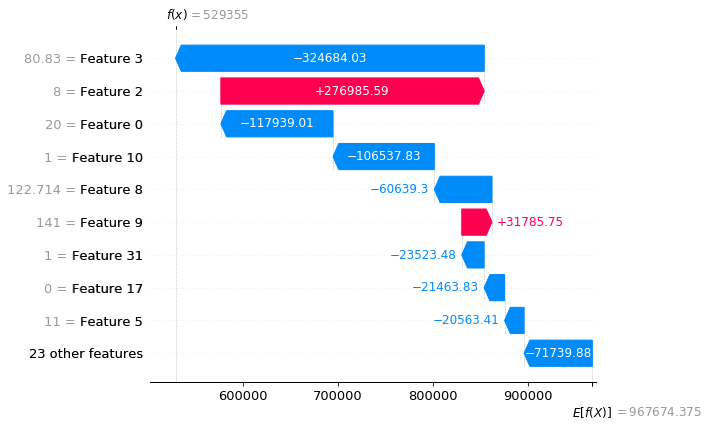

In [24]:
import shap
explainer = shap.Explainer(optimized_rf)
shap_values = explainer(OHE_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [47]:
cols = X_train.columns.tolist()
cols += [str(i) for i in range(0, 16)]
len(cols)

32

In [48]:
df_train = pd.DataFrame(OHE_train, columns = cols)

In [49]:
df_test = pd.DataFrame(OHE_test, columns = cols)

In [51]:
optimized_rf.fit(df_train, y_train)

[00:24:28] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { min_samples_leaf, n_fold } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.2, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, min_samples_leaf=2, missing=None,
             monotone_constraints='()', n_estimators=300, n_fold=5, n_jobs=1,
             nthread=1, num_parallel_tree=1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=0, silent=None, subsample=0.9, ...)

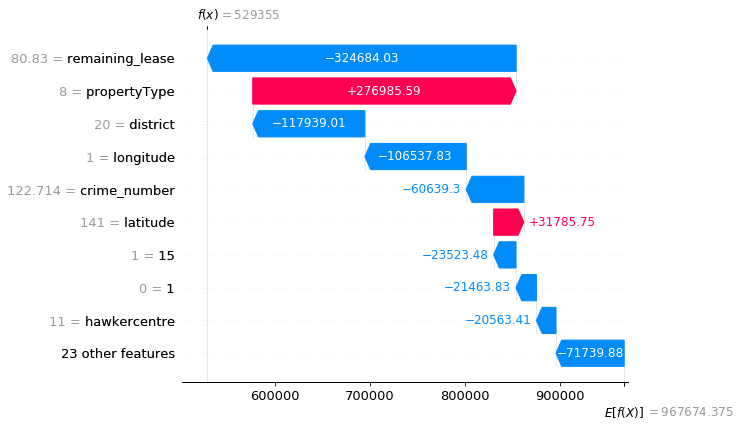

In [52]:
import shap
explainer = shap.Explainer(optimized_rf)
shap_values = explainer(df_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

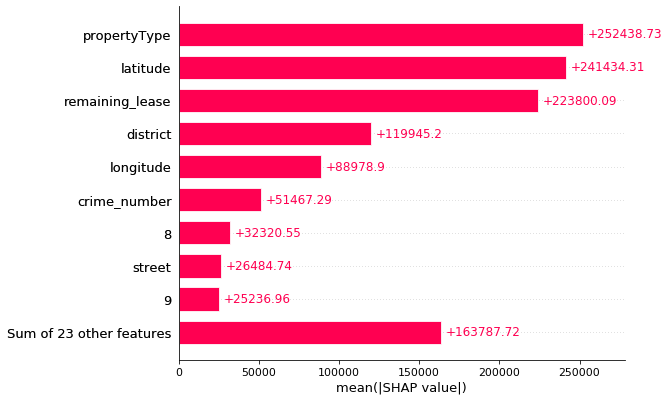

In [53]:
shap.plots.bar(shap_values)

In [20]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(optimized_rf, open(filename, 'wb'))

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
import xgboost
from xgboost import XGBRegressor


# Initialise LGBMRegressor
# rf = LGBMRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')
optimized_rf = XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=0.2,
                              colsample_bytree=1, eval_metric='rmse', gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, min_samples_leaf=2,
                              missing=None, n_estimators=300, n_fold=5,
                              n_jobs=1, nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=0.9, verbosity=1)


# # # Set up 5-fold cross-validation
# from sklearn import model_selection
# cv = model_selection.KFold(5)


# # Pipeline Standardization and Model
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
#                            , ('model', rf) ])
# # Tuning the model
# my_min_samples_leaf = [2, 10, 25, 50, 100]
# my_max_depth = [7, 8, 9, 10, 11, 12]
# my_subsample = [0.7, 0.8, 0.9]
# my_colsample_bytree = [0.1, 0.2, 0.3]

# # Run the model using GridSearch, select the model with best search
# from sklearn.model_selection import GridSearchCV
# optimized_rf = GridSearchCV(estimator=pipeline
#                             , cv=cv
#                             , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, 
#                                                model__max_depth = my_max_depth,
#                                                model__subsample = my_subsample,
#                                                model__colsample_bytree = my_colsample_bytree)
#                             , scoring = 'neg_mean_squared_error'
#                             , verbose = 1
#                             , n_jobs = -1
#                            )

# Fitting on Training Data
optimized_rf.fit(OHE_train, y_train)


# Best model estimators
# print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(OHE_train)
y_pred = optimized_rf.predict(OHE_test)
n1 = len(y_train_pred)
p1 = training_set.shape[1]
n2 = len(y_pred)
p2 = testing_set.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("RMSE: ", mean_squared_error(y_train, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_train_pred))
print("R-squared: ", r2_score(y_train, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_train, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("R-squared: ", r2_score(y_test, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_test, y_pred), n2, p2))



[14:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Errors
Mean Squared Error:  12551992028.521044
RMSE:  112035.67301766454
Mean Absolute Error:  51479.346560496706
R-squared:  0.9955153154058346
Adjusted R2:  0.9955147282789812
Test Errors
Mean Squared Error:  72116357746.47386
RMSE:  268544.8896301582
Mean Absolute Error:  74558.02547936206
R-squared:  0.9657383499618781
Adjusted R2:  0.9657204005138171


In [27]:
print('Training sMAPE')
print(smape(y_train_pred, y_train))
print('Testing sMAPE')
print(smape(y_pred, y_test))

Training sMAPE
5.418052917646694
Testing sMAPE
6.164298821910724


In [28]:
print('Training MAPE')
print(mape(y_train_pred, y_train))
print('Testing MAPE')
print(mape(y_pred, y_test))

Training MAPE
5.41039623682465
Testing MAPE
6.1527569561702355


## No feature cross

## LightGBM

> With GridSearch

## REFER TO THIS FOR RESULTS FOR LIGHTGBM NO FEATURE CROSS

* Training Errors
> * Mean Squared Error:  154748781024.69647
> * RMSE:  393381.21590220404
> * Mean Absolute Error:  97869.27002052014
> * R-squared:  0.9447100131476823
> * Adjusted R2:  0.9447027746818947
> * Training sMAPE: 8.692195215735234
> * Training MAPE: 8.755165504591561

* Test Errors
> * Mean Squared Error:  109857614878.14053
> * RMSE:  331447.75588038086
> * Mean Absolute Error:  103059.25251342994
> * R-squared:  0.9478079138687274
> * Adjusted R2:  0.9477805707857713
> * Testing sMAPE: 8.932541697320472
> * Testing MAPE: 9.001885667238648




In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

# Initialise LGBMRegressor
# rf = LGBMRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')
optimized_rf = LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=0.3, eval_metric='rmse',
                               importance_type='split', learning_rate=0.1,
                               max_depth=8, min_child_samples=20,
                               min_child_weight=0.001, min_samples_leaf=2,
                               min_split_gain=0.0, n_estimators=300, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=0.7, subsample_for_bin=200000,
                               subsample_freq=0)


# # # Set up 5-fold cross-validation
# from sklearn import model_selection
# cv = model_selection.KFold(5)


# # Pipeline Standardization and Model
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
#                            , ('model', rf) ])
# # Tuning the model
# my_min_samples_leaf = [2, 10, 25, 50, 100]
# my_max_depth = [7, 8, 9, 10, 11, 12]
# my_subsample = [0.7, 0.8, 0.9]
# my_colsample_bytree = [0.1, 0.2, 0.3]

# # Run the model using GridSearch, select the model with best search
# from sklearn.model_selection import GridSearchCV
# optimized_rf = GridSearchCV(estimator=pipeline
#                             , cv=cv
#                             , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, 
#                                                model__max_depth = my_max_depth,
#                                                model__subsample = my_subsample,
#                                                model__colsample_bytree = my_colsample_bytree)
#                             , scoring = 'neg_mean_squared_error'
#                             , verbose = 1
#                             , n_jobs = -1
#                            )

# Fitting on Training Data
optimized_rf.fit(training_set, training_labels)


# Best model estimators
# print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(training_set)
y_pred = optimized_rf.predict(testing_set)
n1 = len(y_train_pred)
p1 = training_set.shape[1]
n2 = len(y_pred)
p2 = testing_set.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(training_labels, y_train_pred))
print("RMSE: ", mean_squared_error(training_labels, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(training_labels, y_train_pred))
print("R-squared: ", r2_score(training_labels, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(training_labels, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(testing_labels, y_pred))
print("RMSE: ", mean_squared_error(testing_labels, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(testing_labels, y_pred))
print("R-squared: ", r2_score(testing_labels, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(testing_labels, y_pred), n2, p2))



Training Errors
Mean Squared Error:  153767951261.52554
RMSE:  392132.56847847457
Mean Absolute Error:  97484.11905487237
R-squared:  0.9450604525136728
Adjusted R2:  0.9450532599267776
Test Errors
Mean Squared Error:  134232725253.18576
RMSE:  366377.84492677194
Mean Absolute Error:  104872.69253333585
R-squared:  0.9362275799832266
Adjusted R2:  0.9361941700412203


In [46]:
train_adj_r_squared = 1 - (1-optimized_rf.score(training_set, training_labels))*(len(training_labels)-1)/(len(training_labels)-training_set.shape[1]-1)
print(train_adj_r_squared)

test_adj_r_squared = 1 - (1-optimized_rf.score(testing_set, testing_labels))*(len(testing_labels)-1)/(len(testing_labels)-testing_set.shape[1]-1)
print(test_adj_r_squared)

0.9450532599267776
0.9361941700412203


In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

# Initialise LGBMRegressor
rf = LGBMRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')
optimized_rf = LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=0.3, eval_metric='rmse',
                               importance_type='split', learning_rate=0.1,
                               max_depth=9, min_child_samples=20,
                               min_child_weight=0.001, min_samples_leaf=2,
                               min_split_gain=0.0, n_estimators=300, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=0.7, subsample_for_bin=200000,
                               subsample_freq=0)


# # Set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)


# Pipeline Standardization and Model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# Tuning the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
my_subsample = [0.7, 0.8, 0.9]
my_colsample_bytree = [0.1, 0.2, 0.3]

# Run the model using GridSearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, 
                                               model__max_depth = my_max_depth,
                                               model__subsample = my_subsample,
                                               model__colsample_bytree = my_colsample_bytree)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )

# Fitting on Training Data
optimized_rf.fit(training_set, training_labels)


# Best model estimators
print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(training_set)
y_pred = optimized_rf.predict(testing_set)
n1 = len(y_train_pred)
p1 = training_set.shape[1]
n2 = len(y_pred)
p2 = testing_set.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(training_labels, y_train_pred))
print("RMSE: ", mean_squared_error(training_labels, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(training_labels, y_train_pred))
print("R-squared: ", r2_score(training_labels, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(training_labels, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(testing_labels, y_pred))
print("RMSE: ", mean_squared_error(testing_labels, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(testing_labels, y_pred))
print("R-squared: ", r2_score(testing_labels, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(testing_labels, y_pred), n2, p2))



Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 23.5min finished


Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=0.3, eval_metric='rmse',
                               importance_type='split', learning_rate=0.1,
                               max_depth=8, min_child_samples=20,
                               min_child_weight=0.001, min_samples_leaf=2,
                               min_split_gain=0.0, n_estimators=300, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=0.7, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)
Training Errors
Mean Squared Error:  154748781024.69647
RMSE:  393381.21590220404
Mean Absolute Err

## Residual Plot (for LightGBM Model)

> Training Residual Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


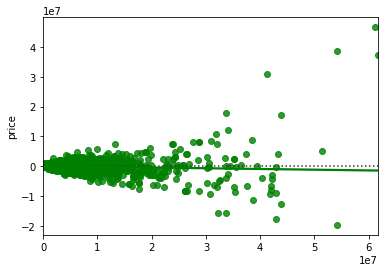

In [49]:
sns.residplot(y_train_pred.reshape(-1), training_labels, lowess= True, color="g")


> Testing Residual Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


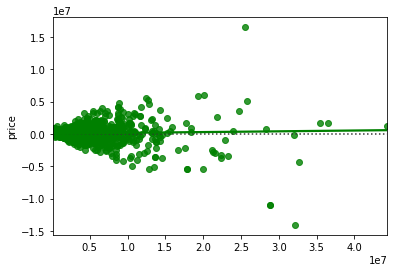

In [50]:
sns.residplot(y_pred.reshape(-1), testing_labels, lowess= True, color="g")

## sMAPE (for LightGBM Model)

In [51]:
def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred.squeeze()-y_true.squeeze()) / (np.abs(y_true.squeeze()) + np.abs(y_pred.squeeze()))*100)

In [52]:
print('Training sMAPE')
print(smape(y_train_pred, training_labels))
print('Testing sMAPE')
print(smape(y_pred, testing_labels))

Training sMAPE
8.692195215735234
Testing sMAPE
8.932541697320472


## MAPE (for LightGBM Model)

In [53]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100



In [54]:
print('Training MAPE')
print(mape(y_train_pred, training_labels))
print('Testing MAPE')
print(mape(y_pred, testing_labels))

Training MAPE
8.755165504591561
Testing MAPE
9.001885667238648


## XGBoost

> With Grid Search

## REFER TO THIS FOR RESULTS FOR XGBOOST NO FEATURE CROSS

* Training Errors
> * Mean Squared Error:  12132880148.301222
> * RMSE:  110149.35382607208
> * Mean Absolute Error:  49759.837263115034
> * R-squared:  0.9956650593339843
> * Adjusted R2:  0.9956644918113371
> * sMAPE: 5.221816592924819
> * MAPE: 5.215358761311443


* Test Errors
> * Mean Squared Error:  64160185612.8874
> * RMSE:  253298.60957551148
> * Mean Absolute Error:  72200.72230554672
> * R-squared:  0.9695182356050535
> * Adjusted R2:  0.9695022664136629
> * sMAPE: 5.968598907734008
> * MAPE: 5.9980976343903105

In [55]:
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn import preprocessing
from xgboost import XGBRFRegressor

# Initialise XGBRegressor
rf = xgboost.XGBRegressor(n_estimators=300, subsample=0.9, colsample_bynode=0.2, n_fold = 5, eval_metric = 'rmse')

# Set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)

# Pipeline standardization and Model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# Tuning the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]


# Run the model using GridSearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )

# Fitting on Training Data
optimized_rf.fit(training_set, training_labels)


# Best model estimators
print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(training_set)
y_pred = optimized_rf.predict(testing_set)
n1 = len(y_train_pred)
p1 = training_set.shape[1]
n2 = len(y_pred)
p2 = testing_set.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(training_labels, y_train_pred))
print("RMSE: ", mean_squared_error(training_labels, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(training_labels, y_train_pred))
print("R-squared: ", r2_score(training_labels, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(training_labels, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(testing_labels, y_pred))
print("RMSE: ", mean_squared_error(testing_labels, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(testing_labels, y_pred))
print("R-squared: ", r2_score(testing_labels, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(testing_labels, y_pred), n2, p2))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 29.5min finished


[08:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=0.2,
                              colsample_bytree=1, eval_metric='rmse', gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, min_samples_leaf=2,
                              missing=None, n_estimators=300, n_fold=5,
                              n_jobs=1, nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,

## Residual Plot (for XGBoost Model)

> Training 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


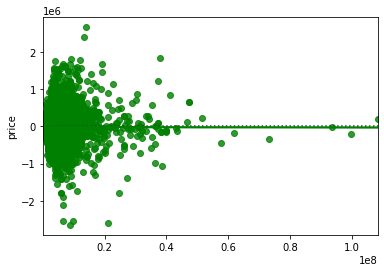

In [56]:
sns.residplot(y_train_pred.reshape(-1), training_labels, lowess= True, color="g")

> Testing 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


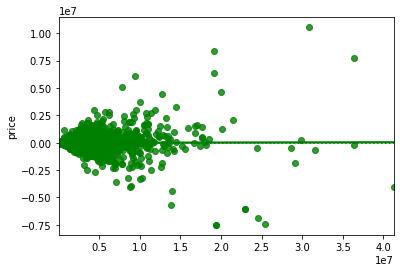

In [57]:
sns.residplot(y_pred.reshape(-1), testing_labels, lowess= True, color="g")

## sMAPE (for XGBoost Model)

In [58]:
print(smape(y_train_pred, training_labels))
print(smape(y_pred, testing_labels))

5.221816592924819
5.968598907734008


## MAPE (for XGBoost Model)

In [59]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print(mape(y_train_pred, training_labels))
print(mape(y_pred, testing_labels))

5.215358761311443
5.9980976343903105
